## 1. DATA PRE-PROCESSING

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

### 1.1 Data Manipulation

In [2]:
# load data
data = pd.read_csv('/Users/junyuchen/Desktop/Master Thesis/code/data/gaa.csv', parse_dates=['vertrag'], index_col=['vertrag'], low_memory=False)
data.index = data.index.to_period('Q').rename('period')

# select variables
data = data[['kalender', 'flaeche', 'gflaeche', 'alter', 'preis']]
data.rename(
    columns = {
        'kalender' : 'period_string',
        'flaeche' : 'lot_size',
        'gflaeche' : 'floor_space',
        'alter' : 'age',
        'preis' : 'price'
    }, inplace=True)

print(f'\nOriginal number of observations: {len(data)}.')

# 1. drop NaNs
data.dropna(inplace=True)
print(f'\nNumber of observations after dropping NANs: {len(data)}.')

# 2. drop negative "alter"
data = data.loc[data["age"] > 0]
print(f'\nNumber of observations after dropping negative "alter": {len(data)}.')

data


Original number of observations: 37203.

Number of observations after dropping NANs: 37203.

Number of observations after dropping negative "alter": 29939.


,period_string,lot_size,floor_space,age,price
period,,,,,
1996Q1,1996q1,480,120,65,242864
1996Q2,1996q2,691,151,61,127823
1996Q3,1996q3,888,164,46,224968
1996Q1,1996q1,750,196,60,178952
1996Q2,1996q2,1105,163,66,230081
...,...,...,...,...,...
2017Q1,2017q1,637,104,53,280000
2017Q2,2017q2,497,105,83,240000
2017Q2,2017q2,144,131,18,425000


#### Logarithm Transformation of Variables

In [3]:
data_log = data.copy()
data_log.loc[:, [
    'lot_size', 'floor_space', 'age', 'price'
]] = np.log(data_log.loc[:, [
    'lot_size', 'floor_space', 'age', 'price'
]])

data_trend = pd.DataFrame({
    'trend' : np.array(range(1, 87)),
    'trend2' : np.power(range(1, 87), 2),
    'period_string' : sorted(pd.unique(data_log['period_string']))
})

data_log = data_log.merge(data_trend, on='period_string', how='left').set_axis(data_log.index)

# drop 2017q2
data_log['id'] = np.arange(len(data_log))
data_log_2017 = data_log.loc[data_log['period_string'] == '2017q2', :]
data_log = data_log.loc[data_log['period_string'] != '2017q2', :]

print(f'\nNumber of observations after dropping "2017q2": {len(data_log)}.')
print(f'Number of observations in 2017: {len(data_log_2017)}, \nNumber of observations except 2017: {len(data_log)}.')
data_log


Number of observations after dropping "2017q2": 29900.
Number of observations in 2017: 39, 
Number of observations except 2017: 29900.


,period_string,lot_size,floor_space,age,price,trend,trend2,id
period,,,,,,,,
1996Q1,1996q1,6.173786,4.787492,4.174387,12.400257,1,1,0
1996Q2,1996q2,6.538140,5.017280,4.110874,11.758402,2,4,1
1996Q3,1996q3,6.788972,5.099866,3.828641,12.323713,3,9,2
1996Q1,1996q1,6.620073,5.278115,4.094345,12.094873,1,1,3
1996Q2,1996q2,7.007601,5.093750,4.189655,12.346187,2,4,4
...,...,...,...,...,...,...,...,...
2017Q1,2017q1,6.597146,4.969813,4.406719,12.818552,85,7225,29921
2017Q1,2017q1,5.517453,4.762174,3.583519,12.762827,85,7225,29922
2017Q1,2017q1,6.570883,4.624973,3.784190,12.736701,85,7225,29923


### 1.2 Missing Observations

$\boldsymbol{y}_t$ is a $N_{t} \times 1$ vector of observable variables at time $t$, where $N_{t}$ denotes the number of observations $\boldsymbol{y}_{t,n}$ in period $t$. Due to the variation of the number of observations over time, we set $N$ to the number of minimum (instead of maximum) observations for a quarter:

$$
N = \min_{t=1,...,T} N_t
$$

In [4]:
# ---------------------------------------------------
# select observations
# ---------------------------------------------------
def select_observations(group):
    return group.sample(n=N, random_state=999)

In [5]:
# check the minimum number of observations 
print(f"Original number of observations for each quarter: \n{data_log.index.value_counts().sort_values()}")

# select the first N observations of each quarter
N = data_log.index.value_counts().sort_values()[0]
#N = 2
df = data_log.groupby(data_log.index).apply(select_observations).reset_index(level=0, drop=True)

print(f"\nThe total number of observations after dropping missing observations: {len(df)}.")
print(df.index.value_counts().sort_values())

df

Original number of observations for each quarter: 
1997Q1    192
2003Q1    198
1996Q1    201
2006Q1    206
2014Q1    214
         ... 
2010Q3    484
2010Q2    486
2011Q2    492
2006Q4    497
2005Q4    637
Freq: Q-DEC, Name: period, Length: 85, dtype: int64

The total number of observations after dropping missing observations: 16320.
1996Q1    192
1997Q1    192
1997Q2    192
1997Q3    192
1997Q4    192
         ... 
2016Q4    192
2012Q3    192
2012Q2    192
2015Q2    192
2017Q1    192
Freq: Q-DEC, Name: period, Length: 85, dtype: int64


,period_string,lot_size,floor_space,age,price,trend,trend2,id
period,,,,,,,,
1996Q1,1996q1,6.815640,4.382027,4.060443,12.555909,1,1,797
1996Q1,1996q1,6.642487,5.087596,4.442651,12.451549,1,1,906
1996Q1,1996q1,6.291569,4.948760,4.077537,12.421091,1,1,170
1996Q1,1996q1,5.631212,4.948760,2.890372,12.650399,1,1,1006
1996Q1,1996q1,5.993961,5.135798,4.330733,12.118869,1,1,750
...,...,...,...,...,...,...,...,...
2017Q1,2017q1,6.175867,4.804021,3.784190,12.570716,85,7225,29880
2017Q1,2017q1,6.326149,4.369448,2.772589,12.891692,85,7225,29698
2017Q1,2017q1,6.388561,4.204693,4.406719,12.367341,85,7225,29878


In [6]:
df_test = data_log[~data_log['id'].isin(df['id'])]
df_test

,period_string,lot_size,floor_space,age,price,trend,trend2,id
period,,,,,,,,
1996Q2,1996q2,6.765039,4.804021,4.204693,12.431346,2,4,5
1996Q2,1996q2,5.236442,4.882802,1.098612,12.451549,2,4,7
1996Q3,1996q3,6.502790,4.624973,4.189655,12.020767,3,9,9
1996Q3,1996q3,6.318968,4.394449,3.828641,11.653044,3,9,11
1996Q2,1996q2,6.801283,5.192957,4.189655,11.940726,2,4,12
...,...,...,...,...,...,...,...,...
2017Q1,2017q1,6.885510,5.252273,4.356709,13.021437,85,7225,29900
2017Q1,2017q1,6.741701,4.762174,3.951244,13.014778,85,7225,29903
2017Q1,2017q1,6.049733,4.382027,3.637586,12.899220,85,7225,29909


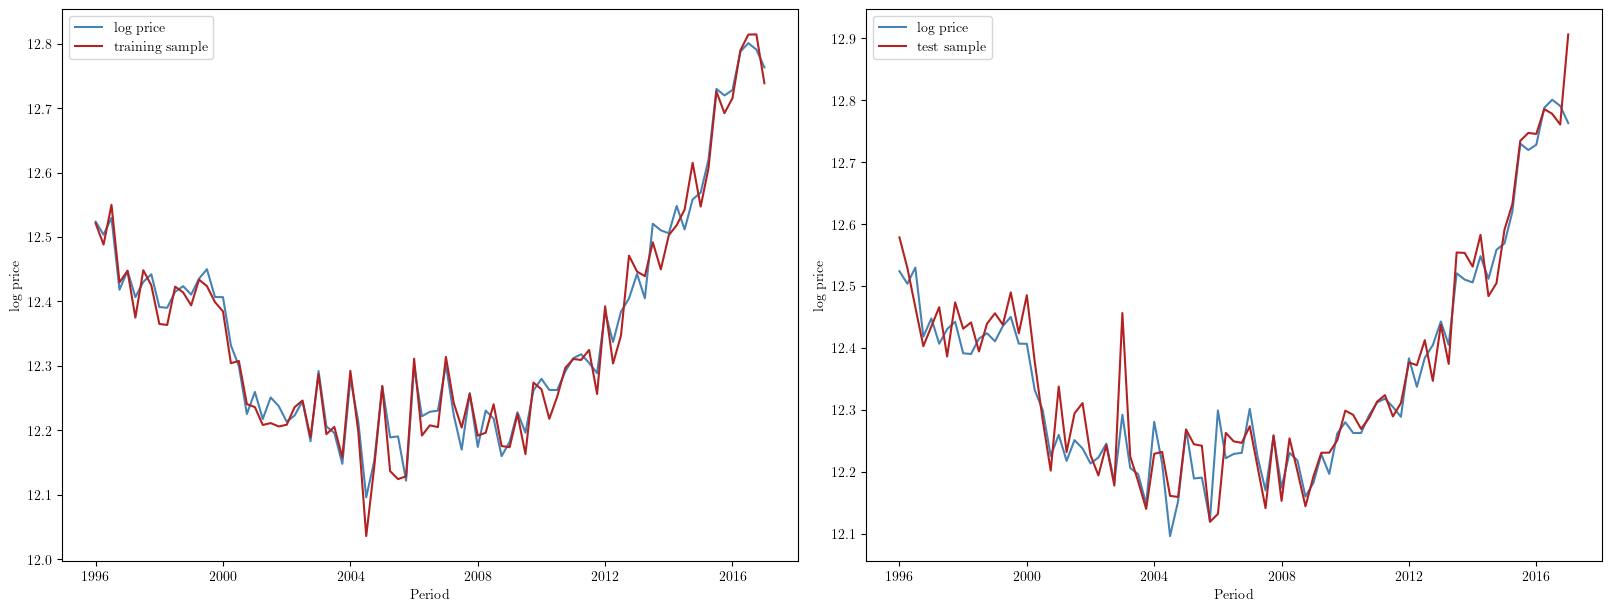

In [7]:
average_log_price = data_log.groupby(data_log.index, sort=True)['price'].mean()
training_average_price = df.groupby(df.index, sort=True)['price'].mean()
test_average_price = df_test.groupby(df_test.index, sort=True)['price'].mean()
x_axis_train = training_average_price.index.to_timestamp()
x_axis_test = test_average_price.index.to_timestamp()

fig, ax = plt.subplots(1, 2, figsize=(16,6), layout="constrained")

ax[0].plot(x_axis_train, average_log_price, label='log price', color='steelblue')
ax[0].plot(x_axis_train, training_average_price, label='training sample', color='firebrick')
ax[0].set_xlabel('Period')
ax[0].set_ylabel('log price')
ax[0].legend()

ax[1].plot(x_axis_train, average_log_price, label='log price', color='steelblue')
ax[1].plot(x_axis_test, test_average_price, label='test sample', color='firebrick')
ax[1].set_xlabel('Period')
ax[1].set_ylabel('log price')
ax[1].legend()

plt.show()

## 2. REGRESSION

In [8]:
from statsmodels.formula.api import ols
from statsmodels.tsa.arima.model import ARIMA

### 2.1 Hedonic Regression

The price function at time $t$:

$$
p_{t,n} = \beta_0 + \beta_{1} x_{t,n}^{\text{(lot size)}} + \beta_{2} x_{t,n}^{\text{(floor space)}} + \beta_{3} x_{t,n}^{\text{(age)}} + \gamma_{t} + \omega_{t,n}
$$

In [9]:
hedonic_reg = ols('price ~ lot_size + floor_space + age + period_string + trend + trend2', data=df).fit()
print(hedonic_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     163.1
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:43:47   Log-Likelihood:                -8488.0
No. Observations:               16320   AIC:                         1.715e+04
Df Residuals:                   16232   BIC:                         1.783e+04
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [10]:
beta0 = hedonic_reg.params[0]
beta1 = hedonic_reg.params[-5]
beta2 = hedonic_reg.params[-4]
beta3 = hedonic_reg.params[-3]
beta4 = hedonic_reg.params[-2]
beta5 = hedonic_reg.params[-1]

sigma_omega_2 = hedonic_reg.mse_resid
print(beta0, beta1, beta2, beta3, beta4, beta5, sigma_omega_2)

7.914665307028585 0.16036025607380477 0.803396914915728 -0.08230825336924244 -0.02160460421190627 0.00029153541855823917 0.16658055580029402


In [11]:
# in-sample
df['hedonic prediciton'] = hedonic_reg.predict(df)
df

,period_string,lot_size,floor_space,age,price,trend,trend2,id,hedonic prediciton
period,,,,,,,,,
1996Q1,1996q1,6.815640,4.382027,4.060443,12.555909,1,1,797,12.172609
1996Q1,1996q1,6.642487,5.087596,4.442651,12.451549,1,1,906,12.680235
1996Q1,1996q1,6.291569,4.948760,4.077537,12.421091,1,1,170,12.542473
1996Q1,1996q1,5.631212,4.948760,2.890372,12.650399,1,1,1006,12.534292
1996Q1,1996q1,5.993961,5.135798,4.330733,12.118869,1,1,750,12.624175
...,...,...,...,...,...,...,...,...,...
2017Q1,2017q1,6.175867,4.804021,3.784190,12.570716,85,7225,29880,12.779653
2017Q1,2017q1,6.326149,4.369448,2.772589,12.891692,85,7225,29698,12.537880
2017Q1,2017q1,6.388561,4.204693,4.406719,12.367341,85,7225,29878,12.281023


In [12]:
# out-sample
df_test['hedonic prediciton'] = hedonic_reg.predict(df_test).copy()
df_test

/var/folders/6k/ydsm3xp92dv0ndc31g4f4lfm0000gn/T/ipykernel_54949/3994606538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['hedonic prediciton'] = hedonic_reg.predict(df_test).copy()


,period_string,lot_size,floor_space,age,price,trend,trend2,id,hedonic prediciton
period,,,,,,,,,
1996Q2,1996q2,6.765039,4.804021,4.204693,12.431346,2,4,5,12.414072
1996Q2,1996q2,5.236442,4.882802,1.098612,12.451549,2,4,7,12.487894
1996Q3,1996q3,6.502790,4.624973,4.189655,12.020767,3,9,9,12.308650
1996Q3,1996q3,6.318968,4.394449,3.828641,11.653044,3,9,11,12.123685
1996Q2,1996q2,6.801283,5.192957,4.189655,11.940726,2,4,12,12.733592
...,...,...,...,...,...,...,...,...,...
2017Q1,2017q1,6.885510,5.252273,4.356709,13.021437,85,7225,29900,13.206453
2017Q1,2017q1,6.741701,4.762174,3.951244,13.014778,85,7225,29903,12.823020
2017Q1,2017q1,6.049733,4.382027,3.637586,12.899220,85,7225,29909,12.432464


The OLS estimates $\hat{\beta}_{0}, \hat{\beta}_{1}, \hat{\beta}_{2}, \hat{\beta}_{3}, \hat{\sigma}_{\omega}^{2}$ are obtained:

| Estimates by OLS                                     | |
| :--------------------------------------------------- | |
| $\hat{\beta}_{0}$                                    | $7.9146$  |
| $\hat{\beta}_{1} = \hat{\beta}_{\text{lot size}}$    | $0.1604$  |
| $\hat{\beta}_{2} = \hat{\beta}_{\text{floor space}}$ | $0.8034$  |
| $\hat{\beta}_{3} = \hat{\beta}_{\text{age}}$         | $-0.0823$ |
| $\hat{\beta}_{4} = \hat{\beta}_{\text{trend}}$       | $-0.0216$ |
| $\hat{\beta}_{5} = \hat{\beta}_{\text{trend2}}$      | $-0.0003$ |
| $\hat{\sigma}_{\omega}^{2}$                          | $0.1666$  |

and the estimated common price component $\hat{\Gamma} = \{ \hat{\gamma}_{1}, \hat{\gamma}_{2}, ...,  \hat{\gamma}_{T} \}$ (Note that $\hat{\gamma}_{0}$ is set to $0$):

In [13]:
gamma = hedonic_reg.params.copy()[0:-5].values
gamma[0] = 0

periods = pd.period_range(start="1996Q1", end="2017Q1", freq="Q")
gamma = pd.Series(gamma, index=periods)
gamma

1996Q1    0.000000
1996Q2   -0.056848
1996Q3    0.042540
1996Q4   -0.047257
1997Q1   -0.078108
            ...   
2016Q1    0.070260
2016Q2    0.176037
2016Q3    0.151145
2016Q4    0.096992
2017Q1    0.056606
Freq: Q-DEC, Length: 85, dtype: float64

### 2.2 Auto-Regressive (AR) Process

The commen price component function can be written as an AR(2) process:

$$
I_{t} = \delta + \phi_{1} \cdot I_{t-1} + \phi_{2} \cdot I_{t-2} + \nu_{t}
$$

_ARIMA()_ implements full Maximum Likelihood and so uses the available information in the first observation when estimating parameters. https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   85
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 142.981
Date:                Fri, 03 Nov 2023   AIC                           -279.961
Time:                        14:43:47   BIC                           -272.634
Sample:                             0   HQIC                          -277.014
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.016      0.078      0.938      -0.030       0.033
ar.L1          0.6903      0.092      7.483      0.000       0.510       0.871
sigma2         0.0020      0.000      6.776      0.0

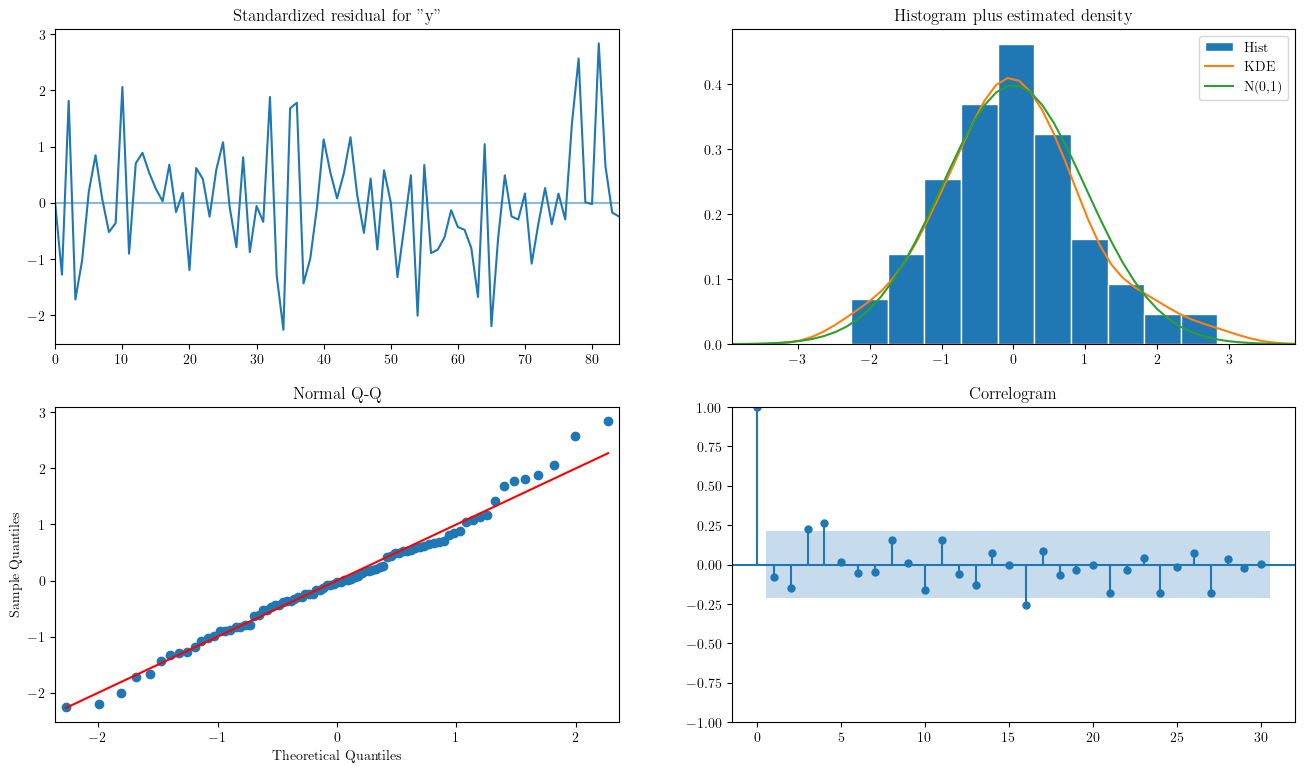

In [14]:
# ---------------------------------------------------
# MLE
# ---------------------------------------------------
ar1 = ARIMA(gamma.values, order=(1,0,0)).fit()
print(ar1.summary())

fig = plt.figure(figsize=(16, 9))
fig = ar1.plot_diagnostics(fig=fig, lags=30)

In [15]:
phi1 = ar1.params[1]
sigma_nu_2 = ar1.params[2]

print(phi1, sigma_nu_2)

0.6903408872063074 0.0020092997961760487


The estimated parameters of AR(2) model:

| Estimates of AR(2)       | |
| :----------------------- | |
| $\hat{\phi}_{1}$         | $0.6639$  |
| $\hat{\sigma}_{\nu}^{2}$ | $0.0022$  |

## 3. KALMAN FILTER AND SMOOTHER

In [16]:
from numpy.linalg import slogdet, pinv

#### Formulating Y and Z Matrices for State Space Representation

In [17]:
# ---------------------------------------------------
# reshape dataframes
# ---------------------------------------------------
def reshape_dataframe(df):
    """
    Reshape the dataframe into state-space form
    
    Args:
        df:           dataframe to be reshaped
        
    Return:
        df_trans:     N x T if endogenous, (number of exogenous * N) x T if exogenous
    """
    
    # add a new column that cumcounts the observations in one quarter
    df['n'] = df.groupby(df.index).cumcount()
    # convert the DataFrame from a wide format to a long format
    df_long = df.set_index([df.index, 'n']).stack(dropna=False)
    # convert it back into separate columns with "vertrag" values
    df_trans = df_long.unstack('period')
    
    df_trans.index = df_trans.index.set_names(["n", "variables"])
    
    return df_trans.fillna(0)

# ---------------------------------------------------
# generate the measurement matrix
# ---------------------------------------------------
def generate_measurement_matrix(X, N, time_length, n_invariant, n_variant):
    """
    Reshape the measurement matrix
    
    Args:
        X:            N x T, input matrix
        N:            scalar, number of observations in each period N
        time_length:  scalar
        n_invariant:  scalar, number of time-invariant entries
        n_variant:    scalar, number of time-variant entries
        
        
    Return: 
        Z:            N x K x T, design matrix
    """
    
    # constant part
    Z_constant = np.zeros((N, n_invariant, time_length))
    for t in range(time_length):
        Z_constant[:, :, t] = np.tile([1, 1], (N, 1))
    
    # time-varying part
    Z_time_varing = np.zeros((N, n_variant, time_length))
    for n in range(N):
        Z_time_varing[n] = X.loc[n]
    
    Z = np.concatenate((Z_constant, Z_time_varing), axis=1)
    
    return Z

In [18]:
df[['lot_size', 'floor_space', 'age', 'trend', 'trend2']]

,lot_size,floor_space,age,trend,trend2
period,,,,,
1996Q1,6.815640,4.382027,4.060443,1,1
1996Q1,6.642487,5.087596,4.442651,1,1
1996Q1,6.291569,4.948760,4.077537,1,1
1996Q1,5.631212,4.948760,2.890372,1,1
1996Q1,5.993961,5.135798,4.330733,1,1
...,...,...,...,...,...
2017Q1,6.175867,4.804021,3.784190,85,7225
2017Q1,6.326149,4.369448,2.772589,85,7225
2017Q1,6.388561,4.204693,4.406719,85,7225


In [19]:
# generate Y
y = reshape_dataframe(pd.DataFrame(df['price'])).values
print(f"\nShape of matrix y: {y.shape}")

# generate Z
x = reshape_dataframe(df[['lot_size', 'floor_space', 'age', 'trend', 'trend2']].copy())

time_length = y.shape[1]
Z = generate_measurement_matrix(x, N, time_length, n_invariant=2, n_variant=5)
print(f"\nShape of matrix Z: {Z.shape}")


Shape of matrix y: (192, 85)

Shape of matrix Z: (192, 7, 85)


In [20]:
Z[:,:,0][0]

array([1.        , 1.        , 6.81563999, 4.38202663, 4.06044301,
       1.        , 1.        ])

### 3.1 Initialization

#### State-Space Model

State equation: <br>
$\boldsymbol{\alpha}_{t} = \mathbf{T} \boldsymbol{\alpha}_{t−1} + \boldsymbol{\epsilon}_{t}^{s}$ <br>

Measurement equation: <br>
$\boldsymbol{y}_{t} = \mathbf{Z}_{t} \boldsymbol{\alpha}_{t} + \boldsymbol{\epsilon}_{t}^{m}$ <br>

where <br>
$\boldsymbol{\epsilon}_{t}^{s} \sim N(0, \mathbf{R})$, <br>
$\boldsymbol{\epsilon}_{t}^{m} \sim N(0, \mathbf{H})$. <br>

$$
\alpha = \begin{pmatrix}
         \gamma_t     \\
         \beta_0 \\
         \beta_1 \\
         \beta_2 \\
         \beta_3 \\
         \beta_4 \\
         \beta_5 \\
         \end{pmatrix}
$$

* State equation matrices:

$$
\mathbf{T} = \begin{pmatrix}
             \phi_1 & 0 & 0 & 0 & 0 & 0 & 0\\
             0      & 1      & 0 & 0 & 0 & 0 & 0\\
             0      & 0      & 1 & 0 & 0 & 0 & 0\\
             0      & 0      & 0 & 1 & 0 & 0 & 0\\
             0      & 0      & 0 & 0 & 1 & 0 & 0\\
             0      & 0      & 0 & 0 & 0 & 1 & 0\\
             0      & 0      & 0 & 0 & 0 & 1 & 1\\
             \end{pmatrix} 
\quad
\mathbf{R} = \begin{pmatrix}
             \sigma_v^2 & 0 & 0 & 0 & 0 & 0 \\
             0          & 0 & 0 & 0 & 0 & 0 \\
             0          & 0 & 0 & 0 & 0 & 0 \\
             0          & 0 & 0 & 0 & 0 & 0 \\
             0          & 0 & 0 & 0 & 0 & 0 \\
             0          & 0 & 0 & 0 & 0 & 0 \\
            \end{pmatrix} 
\quad
$$

* Measurement equation matrices:

$$
\mathbf{Z}_t = \begin{pmatrix}
               1      & 0      & 1      & x_{(var_1,1)} & x_{(var_2,1)} & x_{(var_3,1)} \\
               1      & 0      & 1      & x_{(var_1,2)} & x_{(var_2,2)} & x_{(var_3,2)} \\
               \vdots & \vdots & \vdots & \vdots        & \vdots        & \vdots        \\
               1      & 0      & 1      & x_{(var_1,N)} & x_{(var_2,N)} & x_{(var_3,N)} \\
               \end{pmatrix} 
\quad
\mathbf{H} = \begin{pmatrix}
             \sigma_\epsilon^2 & 0                 & \dots  & 0_{(N)}     \\
             0                 & \sigma_\epsilon^2 & \dots  & 0_{(N)}     \\
             \vdots            & \vdots            & \ddots & \vdots      \\
             0_{(N)}           & 0_{(N)}           & \dots  & \sigma_{\epsilon, (N,N)}^2 \\
             \end{pmatrix}
$$

Note that the matrix $\mathbf{Z}$ is of the shape $N \times K \times T$ and the matrix $\mathbf{H}$ is of the shape $N \times N$

In [21]:
def vec(matrix):
    """
    Turns a matrix into a column vector by vertically stacking the columns on top of each other.
    """
    
    column_vector = matrix.flatten(order="F").reshape(-1, 1)
    
    return column_vector

In [22]:
# state equation matrices
T = np.array([[phi1, 0, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 1]])
R = np.array([[sigma_nu_2, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0]])

# measurement equation matrices (NxN)
H = np.eye(N) * sigma_omega_2

In [23]:
# Initialization of the state
mu = np.array([[gamma.mean()], [beta0], [beta1], [beta2], [beta3], [beta4], [beta5]]) 

vec_Sig = np.dot(pinv(np.eye(len(mu)**2) - np.kron(T, T)), vec(R))
Sig = vec_Sig.reshape(R.shape, order='F')
#Sig = np.diag((10, 10, 10, 10, 10, 10, 10))
#Sig = np.diag((1, 0, 0, 0, 0, 0, 0))
mu, Sig

(array([[-1.62045317e-04],
        [ 7.91466531e+00],
        [ 1.60360256e-01],
        [ 8.03396915e-01],
        [-8.23082534e-02],
        [-2.16046042e-02],
        [ 2.91535419e-04]]),
 array([[0.00383872, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ]]))

### 3.2 Kalman Filter

#### Likelihood Function

The log-likelihood function can be written using the "innovations" form:

$$
\ln(\mathcal{L}(\mathbf{\psi})) = - \frac{1}{2} \sum_{t=1}^T \ln|\mathbf{F}_t| - \frac{1}{2} \sum_{t=1}^{T}\mathbf{v}_t^\top \mathbf{F}_t^{-1} \mathbf{v}_t
$$

where

* Innovation: <br>
$\mathbf{v}_t = \mathbf{y}_t - \mathbf{Z}_t \mathbf{a}_{t|t-1}$

* Covariance matrix of the innovation $N_t × N_t$: <br>
$\mathbf{F}_t = \mathbf{Z}_t \mathbf{P}_{t|t-1} \mathbf{Z}_t^\top + \mathbf{H}$

* Kalman Gain: <br>
$\mathbf{W}_t = \mathbf{P}_{t|t-1} \mathbf{Z}_t^\top \mathbf{F}_t^{-1}$

A Kalman Filtering is carried out in two steps: **Prediction** and **Update**. 

* The prediction step, where the next state of the system is predicted given the previous measurements, 
* The update step, where the current state of the system is estimated given the measurement at that time step.<br>

Each step is investigated and coded as a function with matrix input and output.

#### Prediction Step

This step has to predict the mean $\mathbf{a}_{t|t-1}$ and the covariance $\mathbf{P}_{t|t-1}$ of the system state at the time step $t$.

$$
\mathbf{a}_{t|t-1} = \mathbf{T} \cdot \mathbf{a}_{t-1}
$$
$$
\mathbf{P}_{t|t-1} = \mathbf{T} \cdot \mathbf{P}_{t-1} \cdot \mathbf{T}^\top + \mathbf{R}
$$

#### Update Step

At the time step $t$ , the update step computes the posterior mean $\mathbf{a}_t$ and covariance $\mathbf{P}_t$ of the system state given a new measurement $\mathbf{y}_t$.

$$
\begin{align*}
\mathbf{a}_t 
& = \mathbf{a}_{t|t-1} + \mathbf{P}_{t|t-1} \mathbf{Z}_t^\top \mathbf{F}_t^{-1} \mathbf{v}_t \\
& = \mathbf{a}_{t|t-1} + \mathbf{W}_t \mathbf{v}_t 
\end{align*}
$$
$$
\begin{align*}
\mathbf{P}_t 
& = \mathbf{P}_{t|t-1} - \mathbf{P}_{t|t-1} \mathbf{Z}_t^\top \mathbf{F}_t^{-1} \mathbf{Z}_t \mathbf{P}_{t|t-1} \\
& = \mathbf{P}_{t|t-1} - \mathbf{W}_t \mathbf{Z}_t \mathbf{P}_{t|t-1}
\end{align*}
$$

In [24]:
# ---------------------------------------------------
# kalman filter prediction-step
# ---------------------------------------------------
def kalman_filter_predict(a, P, T, R):
    """
    Args:
        a(t-1):    K x 1, estimated state mean at time t-1
        P(t-1):    K x K, estimated state covariance at time t-1
        T:         K x K, transition matrix
        R:         K x K, process noise covariance matrix
        
    Return:
        a(t|t-1):  K x 1, prior of state mean state at time t
        P(t|t-1):  K x K, prior of state covariance at time t
    """
    
    # priors
    a = np.dot(T, a)
    P = np.dot(T, np.dot(P, T.T)) + R
    
    return a, P

# ---------------------------------------------------
# kalman filter update-step
# ---------------------------------------------------
def kalman_filter_update(a, P, yt, Zt, H):
    """
    Args:
        a(t|t-1):   K x 1, prior state mean at time t
        P(t|t-1):   K x K, prior state covariance at time t
        yt:         N x 1, measurement vector at time t
        Zt:         N x K, measurement matrix at time t
        H:          N x N, measurement covariance matrix
        
    Return:
        a(t):       K x 1, posterior at time t
        P(t):       K x K, posterior at time t
        Kt:         K x N, Kalman Gain at time t
        logL_t:     scalar, loglikelihood at time t
    """
    
    # predicted y_t
    yt_pred = np.dot(Zt, a)
    # innovation
    vt = yt - yt_pred
    # Covariace matrix of the innovation
    Ft = np.dot(Zt, np.dot(P, Zt.T)) + H
    # Kalman Gain
    Kt = np.dot(P, np.dot(Zt.T, pinv(Ft)))
    
    # log-likelihood
    logL_t = (-0.5 * slogdet(Ft)[1]) + (-0.5 * np.dot(vt.T, np.dot(pinv(Ft), vt)))
    
    # posteriors
    a = a + np.dot(Kt, vt)
    P = P - np.dot(Kt, np.dot(Zt, P))
    
    return a, P, Kt, vt, Ft, logL_t[0]

# ---------------------------------------------------
# kalman filter
# ---------------------------------------------------
def kalman_filter(mu, Sig, T, R, Z, H, y):
    """
    Args:
        mu:           K x 1, initial state mean
        Sig:          K x K, initial state covariance
        T:            K x K, transition matrix
        R:            K x K, process noise covariance matrix
        Z:            N x K x T, measurement matrix
        H:            N x N, measurement covariance matrix
        Y:            N x T, measurement vector
    
    Return:
        a_pred:       list of K x 1 arrays, predicted state mean
        P_pred:       list of K x K arrays, predicted state covariance
        a_filt:       list of K x 1 arrays, filtered state mean
        P_filt:       list of K x K arrays, filtered state covariance
        W:            list of K x N arrays, Kalman Gain
        logL:         scalar, loglikelihood summed over t
    """
    
    a_pred = [None]
    P_pred = [None]
    a_filt = [mu]
    P_filt = [Sig]
    K = []
    F = []
    v = []
    logL = 0
    
    a = mu
    P = Sig
    
    for t in np.arange(y.shape[1]): 
        
        yt = y[:, t, np.newaxis]
        Zt = Z[:, :, t]
        
        # prediction step
        a, P = kalman_filter_predict(a, P, T, R)
        a_pred.append(a)
        P_pred.append(P)
        
        # update step
        a, P, Kt, vt, Ft, logL_t = kalman_filter_update(a, P, yt, Zt, H)
        
        # log-likelihood
        logL += logL_t
        
        # kalman gain, innovations, covariance matrix of innovations
        K.append(Kt)
        v.append(vt)
        F.append(Ft)
        
        a_filt.append(a)
        P_filt.append(P)
    
    return a_pred, P_pred, a_filt, P_filt, K, v, F, logL

### 3.3 Kalman Smoother

Kalman smoother is the backward recursions for $t = T, T-1, ..., 1$ on the following equations:

$$
\mathbf{J}_{t-1} = \mathbf{P}_{t-1} \mathbf{T}^\top (\mathbf{P}_{t|t-1})^{-1}
$$

$$
\mathbf{a}_{t-1|T} = \mathbf{a}_{t-1} + \mathbf{J}_{t-1} (\mathbf{a}_{t|T} - \mathbf{T} \mathbf{a}_{t-1})
$$

$$
\mathbf{P}_{t-1|T} = \mathbf{P}_{t-1} + \mathbf{J}_{t-1} (\mathbf{P}_{t|T} - \mathbf{P}_{t|t-1}) \mathbf{J}_{t-1}^\top
$$

In [25]:
def kalman_smoother(a_pred, P_pred, a_filt, P_filt, K, T, Z):
    """
    Args:
        a_pred:         list of K x 1 arrays, predicted state mean
        P_pred:         list of K x K arrays, predicted state covariance
        a_filt:         list of K x 1 arrays, filtered state mean
        P_filt:         list of K x K arrays, filtered state covariance
        W:              list of K x N arrays, Kalman Gain
        T:              K x K, transition matrix
        Z:              N x K x T, measurement matrix
    
    Return:
        a_smooth:     list of K x 1 arrays, smoothed state mean
        P_smooth:     list of K x K arrays, smoothed state covariance
        cov_lag1:     list of K x K arrays, smoothed lag one covariance P_{t-1, t-2 | T}
    """
    
    # initialize with the last filtered state
    a_smooth = [a_filt[-1]]
    P_smooth = [P_filt[-1]]
    # initialize
    J = []
    I = np.eye(a_filt[0].shape[0])
    cov_lag1 = [np.dot(np.dot((I - K[-1].dot(Z[:,:,-1])), T), P_filt[-2])]
    
    for t in range(len(a_filt)-2, -1, -1): # for T-1 -> 0 (85 -> 0)
        
        # smoothing gain
        Jt = np.dot(P_filt[t], np.dot(T.T, pinv(P_pred[t+1])))
        # smoothed estimates
        a_smooth_t = a_filt[t] + np.dot(Jt, (a_smooth[-1] - np.dot(T, a_filt[t])))
        P_smooth_t = P_filt[t] + np.dot(Jt, np.dot(P_smooth[-1] - P_pred[t+1], Jt.T))
        
        J.append(Jt)
        a_smooth.append(a_smooth_t)
        P_smooth.append(P_smooth_t)
    
    #J.reverse()
    
    for t in range(len(a_filt)-2, 0, -1): # T-1 -> 1 (85 -> 1)
        
        # smoothed lag one covariance
        cov_lag1_t = np.dot(P_filt[t], J[t-1].T) + np.dot(np.dot(J[t], (cov_lag1[-1] - T.dot(P_filt[t]))), J[t-1].T)
        cov_lag1.append(cov_lag1_t)
    
    # reverse the order of the lists 
    a_smooth.reverse()
    P_smooth.reverse()
    cov_lag1.reverse()
    
    return a_smooth, P_smooth, cov_lag1

## 5. EM Algorithm

The EM algorithm for state space models is based on the Kalman filter. This filter is used to get estimates of the hidden states. The state estimates are then used to improve the estimates of the process parameters.

* **Expectation Step:**
computes the expected values of the latent variables given the current parameter estimates. 
conditional expected values of the hidden states $\mathbf{a}_t$ and its covariance $\mathbf{P}_t$ are obtained using the Kalman filter and smoother.

* **Maximization Step:**
the expected value of the likelihood is maximized with respect to the parameters, yielding a new set of parameters.

The recommended procedure for the EM computations is as follows:

1. Calculate $\mathbf{a}_{t|T}$, $\mathbf{P}_{t|T}$, $\mathbf{P}_{t,t-1|T}$ using the kalman recursions with the initial estimators $\mu(0), \mathbf{T}(0), \mathbf{R}(0), \mathbf{H}(0)$.
2. Update $\mu(1) = \mathbf{a}_{0|T}$ und $\mathbf{T}(1), \mathbf{R}(1), \mathbf{H}(1)$.
3. Repeat 1. and 2. above until the estimates and log likelihood function are stable.

### 5.1 Expected Log-Likelihood Function

We can write the log-likelihood function of the complete data $\mathbf{\alpha}_0, \mathbf{\alpha}_1, ..., \mathbf{\alpha}_T, \mathbf{y}_1, ..., \mathbf{y}_T$ as:

$$
\begin{align*}
\ln(\mathcal{L}(\mathbf{\psi}) | \mathbf{y}_1, \mathbf{y}_2, ..., \mathbf{y}_T) = 
& - \frac{1}{2} \ln|\mathbf{\Sigma}| - \frac{1}{2} (\mathbf{\alpha}_0 - \mathbf{\mu})^\top \mathbf{\Sigma}_t^{-1} (\mathbf{\alpha}_0 - \mu) \\
& - \frac{T}{2} \ln|\mathbf{R}_{sub}| - \frac{1}{2} \sum_{t=1}^{T}(\mathbf{\alpha}_t - \mathbf{T} \mathbf{\alpha}_{t-1})^\top \mathbf{D}^\top \mathbf{R}_{sub}^{-1} \mathbf{D} (\mathbf{\alpha}_t - \mathbf{T} \mathbf{\alpha}_{t-1}) \\
& - \frac{T}{2} \ln|\mathbf{H}| - \frac{1}{2} \sum_{t=1}^{T}(\mathbf{y}_t - \mathbf{Z}_t \mathbf{\alpha}_{t})^\top \mathbf{H}^{-1} (\mathbf{y}_t - \mathbf{Z}_t \mathbf{\alpha}_{t})
\end{align*}
$$

Yet, since $\mathbf{\alpha}_0, \mathbf{\alpha}_1, ..., \mathbf{\alpha}_T$ are unobservable, we consider applying the EM algorithm conditionally with respect to the observed series $\mathbf{y}_1, \mathbf{y}_2, ..., \mathbf{y}_T$. 

Taking conditional expectation on the log-likelihood function yields:

$$
\begin{align*}
\mathbb{E}[\ln \mathcal{L(\psi)} | \mathbf{y}_1, \mathbf{y}_2, ..., \mathbf{y}_T] = 
& - \frac{1}{2} \ln|\mathbf{\Sigma}| - \frac{1}{2} \text{tr} \biggl\{ \mathbf{\Sigma}_t^{-1} (\mathbf{P}_{0|T} + (\mathbf{a}_{0|T} - \mu)) (\mathbf{a}_{0|T} - \mu)^\top) \biggl\} \\
& - \frac{T}{2} \ln|\mathbf{R}_{sub}| - \frac{1}{2} \text{tr} \biggl\{ \mathbf{D}^\top \mathbf{R}_{sub}^{-1} \mathbf{D} (\mathbf{C} - \mathbf{BT}^\top - \mathbf{TB}^\top + \mathbf{TAT}^\top) \biggl\} \\
& - \frac{T}{2} \ln|\mathbf{H}| - \frac{1}{2} \text{tr} \biggl\{ \mathbf{H}^{-1} \sum_{t=1}^{T} \bigr[(\mathbf{y}_t - \mathbf{Z}_t \mathbf{a}_{t|T}) (\mathbf{y}_t - \mathbf{Z}_t \mathbf{a}_{t|T})^\top + \mathbf{Z}_t \mathbf{P}_{t|T} \mathbf{Z}_t^\top) \bigr] \biggl\} \\
\end{align*}
$$

where

$$
\mathbf{A} = \sum_{t=1}^T (\mathbf{P}_{t-1|T} + \mathbf{a}_{t-1|T} \cdot \mathbf{a}_{t-1|T}^\top)
$$

$$
\mathbf{B} = \sum_{t=1}^T (\mathbf{P}_{t,t-1|T} + \mathbf{a}_{t|T} \cdot \mathbf{a}_{t-1|T}^\top)
$$

$$
\mathbf{C} = \sum_{t=1}^T (\mathbf{P}_{t|T} + \mathbf{a}_{t|T} \cdot \mathbf{a}_{t|T}^\top)
$$

In [26]:
def calculate_ABC(a_smooth, P_smooth, cov_lag1):
    """
    Args:
        a_smooth:     list of k x 1 arrays, smoothed state mean
        P_smooth:     list of k x k arrays, smoothed state covariance
        cov_lag1:     list of k x k arrays, smoothed lag one covariance P_{t-1, t-2 | T}
        
    Returns:
        A, B, C:      k x k array
    """

    A = 0
    B = 0
    C = 0
    
    for t in range(len(a_smooth)-1): # 0 -> T-1 = 0 -> 85
        
        A += P_smooth[t] + np.dot(a_smooth[t], a_smooth[t].T)
        B += cov_lag1[t] + np.dot(a_smooth[t+1], a_smooth[t].T)
        C += P_smooth[t+1] + np.dot(a_smooth[t+1], a_smooth[t+1].T)
    
    return A, B, C

def calculate_auxiliary_matrices(T, H):
    
    # for matrix T
    f_T = vec(T)
    f_T[0, 0] = 0
    
    D_T = np.zeros((len(f_T), 1))
    D_T[0] = 1
    
    # for matrix H
    D_H = vec(np.identity(H.shape[0]))
    
    return f_T, D_T, D_H

### 5.3 Maximization Step

* $\hat{\boldsymbol{\mu}}$ is updated by
$$
\hat{\boldsymbol{\mu}}_{j+1} = \tilde{\boldsymbol{\alpha}}_{0}
$$

* $\hat{\boldsymbol{\Sigma}}$ is updated by
$$
\hat{\boldsymbol{\Sigma}}_{j+1} = \tilde{\mathbf{P}}_{0}
$$

* $\hat{\Phi} = \begin{bmatrix} \hat{\phi}_{1} \\ \hat{\phi}_{2} \\ \end{bmatrix}$ of matrix $\mathbf{T}$ is updated by
$$
\hat{\Phi}_{j+1} = \Big( \mathbf{D}_{T}^{\top} (\mathbf{A} \otimes \mathbf{R}^{-1}) \mathbf{D}_{T} \Big) ^{-1} \mathbf{D}_{T}^{\top} \Big( \text{vec}(\mathbf{R}^{-1} \mathbf{B}) - (\mathbf{A} \otimes \mathbf{R}^{-1}) f_{T} \Big)
$$

* $\hat{\sigma}_{\nu}^{2}$ of matrix $\mathbf{R}$ is updated by

$$
\hat{\sigma}_{\nu,j+1}^{2} = T^{-1} ( \mathbf{C} - \mathbf{B} \mathbf{T}^{\top} - \mathbf{T} \mathbf{B}^{\top} + \mathbf{T} \mathbf{A} \mathbf{T}^{\top} )
$$

* $\hat{\sigma}_{\omega}^{2}$ of matrx $\mathbf{H}$ is updated by

$$
\hat{\sigma}_{\omega,j+1}^{2} =  \frac{1}{T N_{t}} \mathbf{D}_{H}^{\top} \text{vec} \Big( \sum_{t=1}^{T} (\boldsymbol{y}_{t} - \mathbf{Z}_{t} \tilde{\boldsymbol{\alpha}}_{t}) (\boldsymbol{y}_{t} - \mathbf{Z}_{t} \tilde{\boldsymbol{\alpha}}_{t})^{\top} + \sum_{t=1}^{T} \mathbf{Z}_{t} \tilde{\boldsymbol{P}}_{t} \mathbf{Z}_{t}^{\top} \Big)
$$
where 
$$
\mathbf{D}_{H} = \text{vec} (\mathbf{I}_{N_{t}})
$$

In [27]:
def maximization_step(a_smooth, P_smooth, cov_lag1, T, R, Z, H, y):
    """
    Args:
        a_smooth:       list of K x 1 arrays, smoothed state mean
        P_smooth:       list of K x K arrays, smoothed state covariance
        cov_lag1:       list of K x K arrays, smoothed lag one covariance P_{t-1, t-2 | T}
        R:              K x K array, transition noise covariance matrix
        
    Returns:
        mu_new:         K x 1 array, initial state mean
        Sig_new:        K x K array, initial state covariance
        T_new:          K x K array, transition matrix
        R_new:          K x K array, process noise covariance matrix
        H_new:          N x N array, measurement covariance matrix
    """
    
    T_new = T.copy()
    R_new = R.copy()
    H_new = H.copy()
    
    # calculate the necessary matrices
    A, B, C = calculate_ABC(a_smooth, P_smooth, cov_lag1)
    f_T, D_T, D_H = calculate_auxiliary_matrices(T, H)
    
    # maximizing mu
    mu_new = a_smooth[0]
    
    # maximizing Sigma
    Sig_new = P_smooth[0]
    
    # maximizing T
    vec_invR_B = vec(np.dot(pinv(R), B)) #36x1
    A_kr_invR = np.kron(A, pinv(R)) #36x36
    
    inversion_term = pinv(np.dot(D_T.T, A_kr_invR.dot(D_T))) #2x2
    vec_term = vec(np.dot(pinv(R), B)) - A_kr_invR.dot(f_T) #36x1
    Phi = np.dot(inversion_term.dot(D_T.T), vec_term) #2x1
    
    T_new[0, 0] = Phi[0, 0]
    
    # maximizing R
    sigma_nu_2 = 1/(len(a_smooth)-1) * (C - np.dot(B, T.T) - np.dot(T, B.T) + np.dot(T.dot(A), T.T))[0,0]
    R_new[0, 0] = sigma_nu_2
    
    # maximizing H
    sum_term = 0
    for t in range(len(a_smooth)-1): # 0 -> 85
        pi_t = y[:, t, np.newaxis] - np.dot(Z[:, :, t], a_smooth[t+1])
        ZPZ_t = np.dot(Z[:, :, t], P_smooth[t+1].dot(Z[:, :, t].T))
        sum_term += np.dot(pi_t, pi_t.T) + ZPZ_t
        
    sigma_omega_2 = np.dot(D_H.T, vec(sum_term))[0, 0] / ((len(a_smooth)-1) * y.shape[0])
    np.fill_diagonal(H_new, sigma_omega_2)
        
    return mu_new, Sig_new, T_new, R_new, H_new

### 5.4 Expectation Step

In [28]:
def expectation_step(mu, Sig, T, R, Z, H, y):
    
    a_pred, P_pred, a_filt, P_filt, K, v, F, logL = kalman_filter(mu, Sig, T, R, Z, H, y)
    a_smooth, P_smooth, cov_lag1 = kalman_smoother(a_pred, P_pred, a_filt, P_filt, K, T, Z)
    
    return a_smooth, P_smooth, cov_lag1, v, F, logL

### 5.5 Estimating by EM

In [29]:
def EM(initial_mu, initial_Sig, initial_T, initial_R, initial_H, Z, y, max_iterations=50, tol=0.01):
    
    mu_estimated = initial_mu
    Sig_estimated = initial_Sig
    T_estimated = initial_T
    R_estimated = initial_R
    H_estimated = initial_H
    
    best_mu = mu_estimated
    best_Sig = Sig_estimated
    best_T = T_estimated
    best_R = R_estimated
    best_H = H_estimated
    
    for it in range(max_iterations):
        
        # E-step
        a_smooth, P_smooth, cov_lag1, v, F, logL = expectation_step(mu_estimated, Sig_estimated, T_estimated, R_estimated, Z, H_estimated, y)
        if it == 0: 
            print(f'intinal log-likelihood: {logL}')
            prev_logL = logL - 0.1
        else:
            print(f'log-likelihood: {logL}')
        
        # M-step
        mu_estimated, Sig_estimated, T_estimated, R_estimated, H_estimated = maximization_step(a_smooth, P_smooth, cov_lag1, T_estimated, R_estimated, Z, H_estimated, y)
        
        if logL > prev_logL:
            print('increasing')
        else:
            print('!!!!!decreasing!!!!! Something is wrong!')
        
        if (logL - prev_logL) < tol:
            print('converged! wowho!')
            break
        
        print(f'{it}-th iteration is done...')
        print('------------------------------')
        best_mu = mu_estimated
        best_Sig = Sig_estimated
        best_T = T_estimated
        best_R = R_estimated
        best_H = H_estimated
        prev_logL = logL
        
    return best_mu, best_Sig, best_T, best_R, best_H, v, F

In [30]:
best_mu, best_Sig, best_T, best_R, best_H, innovations, F = EM(initial_mu=mu, initial_Sig=Sig, 
                                               initial_T=T, initial_R=R, 
                                               Z=Z, initial_H=H, y=y)

print(f'\nmu: \n{best_mu}')
print(f'\nSig: \n{best_Sig}')
print(f'\nT: \n{best_T}')
print(f'\nR: \n{best_R}')
print(f'\nH: \n{best_H}')

intinal log-likelihood: [6426.71594623]
increasing
0-th iteration is done...
------------------------------
log-likelihood: [6429.37178322]
increasing
1-th iteration is done...
------------------------------
log-likelihood: [6430.78189296]
increasing
2-th iteration is done...
------------------------------
log-likelihood: [6431.60898025]
increasing
3-th iteration is done...
------------------------------
log-likelihood: [6432.1226866]
increasing
4-th iteration is done...
------------------------------
log-likelihood: [6432.45405841]
increasing
5-th iteration is done...
------------------------------
log-likelihood: [6432.67355998]
increasing
6-th iteration is done...
------------------------------
log-likelihood: [6432.82181321]
increasing
7-th iteration is done...
------------------------------
log-likelihood: [6432.9234442]
increasing
8-th iteration is done...
------------------------------
log-likelihood: [6432.99394698]
increasing
9-th iteration is done...
-------------------------

In [31]:
a_predicted, P_predicted, a_filtered, P_filtered, kalman_gain, innovations, F, logL = kalman_filter(best_mu, best_Sig, best_T, best_R, Z, best_H, y)
a_smoothed, P_smoothed, cov_lag1 = kalman_smoother(a_predicted, P_predicted, a_filtered, P_filtered, kalman_gain, best_T, Z)
I_filtered = np.array([alpha[0][0] for alpha in a_filtered])
I_smoothed = np.array([alpha[0][0] for alpha in a_smoothed])
CI_filtered = np.array([variance[0][0] for variance in P_filtered])
CI_smoothed = np.array([variance[0][0] for variance in P_smoothed])

## 7. Diagnostic Checking

checking the results by standardized residuals:

$$
v_t^{st} = F_t^{-1/2} v_t
$$

where
$$
F_t^{-1/2} = C_t \Lambda_t^{-1/2} C_t^{\top}
$$

$v_t^{st}$ should follow a multivariate standardized normal distribution.

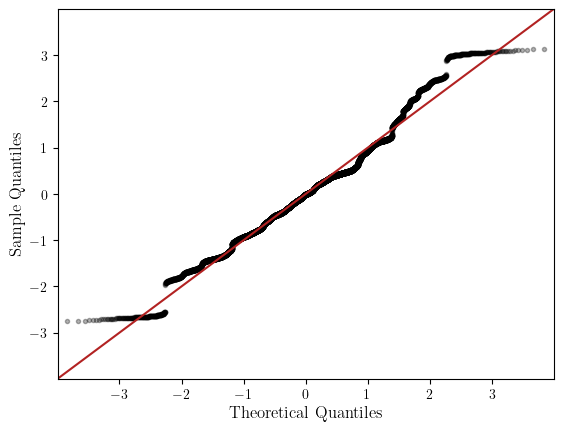

In [32]:
import statsmodels.api as sm
import pylab

def calculate_standard_residuals(v, F):
    
    N = F[0].shape[0]
    T = len(v)
    
    v_sd = np.zeros((N, T))
    
    for t in range(len(v)):
        
        # check if Ft is positive definite
        if np.any(np.linalg.eigvals(F[t]) < 0):
            print(f'The {t}-th F is not positive definite!')
        
        v_sd[:, t, np.newaxis] = np.dot(F[t]**(-0.5), v[t])
        
    return v_sd

v_sd = calculate_standard_residuals(innovations, F)

pp = sm.ProbPlot(v_sd.flatten(), fit=True)
qq = pp.qqplot(marker='.', markerfacecolor='k', markeredgecolor='k', alpha=0.3)
sm.qqline(qq.axes[0], line='45', fmt='k--', color='firebrick')
plt.xlabel('Theoretical Quantiles', fontsize=12)
plt.ylabel('Sample Quantiles', fontsize=12)
plt.savefig('/Users/junyuchen/Desktop/Master Thesis/code/Plots/qq_plot.png')

## Prediction

### In-sample prediction

In [33]:
params = hedonic_reg.params
params[:-5] = I_smoothed[1:]
params[0] = best_mu[1]
#print(params)

df['ssm predict'] = hedonic_reg.predict(df)
mse_ssm = ((df["price"] - df["ssm predict"])**2).mean()
mse_hedonic = ((df["price"] - df["hedonic prediciton"])**2).mean()
print('-----------------In sample--------------------')
print(f' Hedonic RMSE: {np.sqrt(mse_hedonic)}')
print(f' SSM RMSE: {np.sqrt(mse_ssm)}')

df_test['ssm predict'] = hedonic_reg.predict(df_test)

mse_ssm = ((df_test["price"] - df_test["ssm predict"])**2).mean()
mse_hedonic = ((df_test["price"] - df_test["hedonic prediciton"])**2).mean()
print('-----------------out of sample--------------------')
print(f' Hedonic RMSE: {np.sqrt(mse_hedonic)}')
print(f' SSM RMSE: {np.sqrt(mse_ssm)}')

# generalization
print(f' Generalization: {(np.sqrt(mse_hedonic) - np.sqrt(mse_ssm)) / np.sqrt(mse_hedonic)}')

-----------------In sample--------------------
 Hedonic RMSE: 0.40704094058600027
 SSM RMSE: 0.40765051694165244
-----------------out of sample--------------------
 Hedonic RMSE: 0.41622719928980023
 SSM RMSE: 0.4157029305246953
 Generalization: 0.0012595735357983984


/var/folders/6k/ydsm3xp92dv0ndc31g4f4lfm0000gn/T/ipykernel_54949/2687558681.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['ssm predict'] = hedonic_reg.predict(df_test)


### plots average price

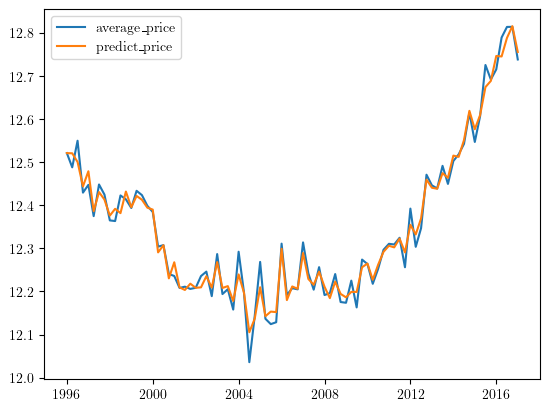

In [34]:
predict_price = df.groupby(df.index, sort=True)['ssm predict'].mean()
average_price = df.groupby(df.index, sort=True)['price'].mean()

plt.plot(gamma.index.to_timestamp(), average_price, label='average_price')
plt.plot(gamma.index.to_timestamp(), predict_price, label='predict_price')
plt.legend()

In [35]:
a_2017q2, P_2017q2 = kalman_filter_predict(a_smoothed[-1], P_smoothed[-1], best_T, best_R)
I_prediction = [I_smoothed[-1], a_2017q2[0][0]]
CI_prediction = [CI_smoothed[-1], P_2017q2[0, 0]]
print(I_prediction)
print(CI_prediction)

# prediction error for 2017q2
data_log_2017['ssm prediction'] = beta0 + data_log_2017['lot_size']*beta1 + data_log_2017['floor_space']*beta2 + data_log_2017['age']*beta3 + data_log_2017['trend']*beta4 + data_log_2017['trend2']*beta5
mse_2017q2 = ((data_log_2017['ssm prediction'] - data_log_2017['price'])**2).mean()
rmse = np.sqrt(mse_2017q2)
rmse

[0.07405055963227686, 0.0659546715566861]
[0.0004769726368604576, 0.0010596398067736212]


0.277743643064602

In [36]:
future = 14

a_new = a_2017q2.copy()
P_new = P_2017q2.copy()
I_prediction = [I_smoothed[-1], a_2017q2[0][0]]
CI_prediction = [CI_smoothed[-1], P_2017q2[0, 0]]

for t in range(future):
    a_new, P_new = kalman_filter_predict(a_new, P_new, best_T, best_R)
    I_prediction.append(a_new[0][0])
    CI_prediction.append(P_new[0, 0])

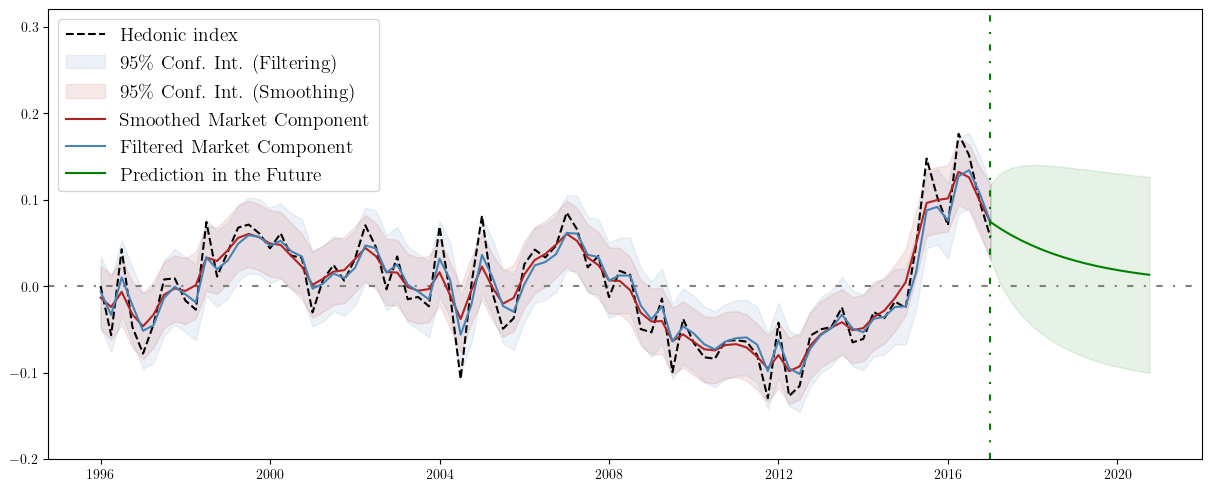

In [37]:
x_axis = gamma.index.to_timestamp()
periods = pd.period_range(start="2017Q1", end="2020Q4", freq="Q")
x_axis2 = periods.to_timestamp()

plt.figure(figsize=(12, 4.8), layout="constrained")

color1 = 'steelblue'
color2 = 'firebrick'
color3 = 'black'

plt.axhline(0, color = 'grey', linestyle=(0, (3, 5, 1, 5)))
plt.plot(x_axis, gamma, color=color3, label='Hedonic index', linestyle='--')

plt.fill_between(x_axis, 
                 I_filtered[1:] - 2*np.sqrt(CI_filtered[1:]), 
                 I_filtered[1:] + 2*np.sqrt(CI_filtered[1:]), 
                 color=color1, label='95$\%$ Conf. Int. (Filtering)', alpha=0.1)
plt.fill_between(x_axis, 
                 I_smoothed[1:] - 2*np.sqrt(CI_smoothed[1:]), 
                 I_smoothed[1:] + 2*np.sqrt(CI_smoothed[1:]), 
                 color=color2, label='95$\%$ Conf. Int. (Smoothing)', alpha=0.1)
# smoothed
plt.plot(x_axis, I_smoothed[1:], color=color2, label='Smoothed Market Component')
# filtered
plt.plot(x_axis, I_filtered[1:], color=color1, label='Filtered Market Component')

# predicted
plt.plot(x_axis2, I_prediction, color='green', label='Prediction in the Future')
plt.fill_between(x_axis2, 
                 I_prediction - 2*np.sqrt(CI_prediction), 
                 I_prediction + 2*np.sqrt(CI_prediction), 
                 color='green', alpha=0.1)
plt.axvline(x=x_axis2[0], color = 'green', linestyle=(0, (3, 5, 1, 5)))

#plt.ylabel('Level of Market Component')
#plt.xlabel('Time Period')
plt.ylim([-0.2, 0.32])
plt.legend(loc='upper left', fontsize=14)
#plt.savefig('/Users/junyuchen/Desktop/Master Thesis/code/Plots/kalman_result.png')
plt.show()

(12.0, 13.0)

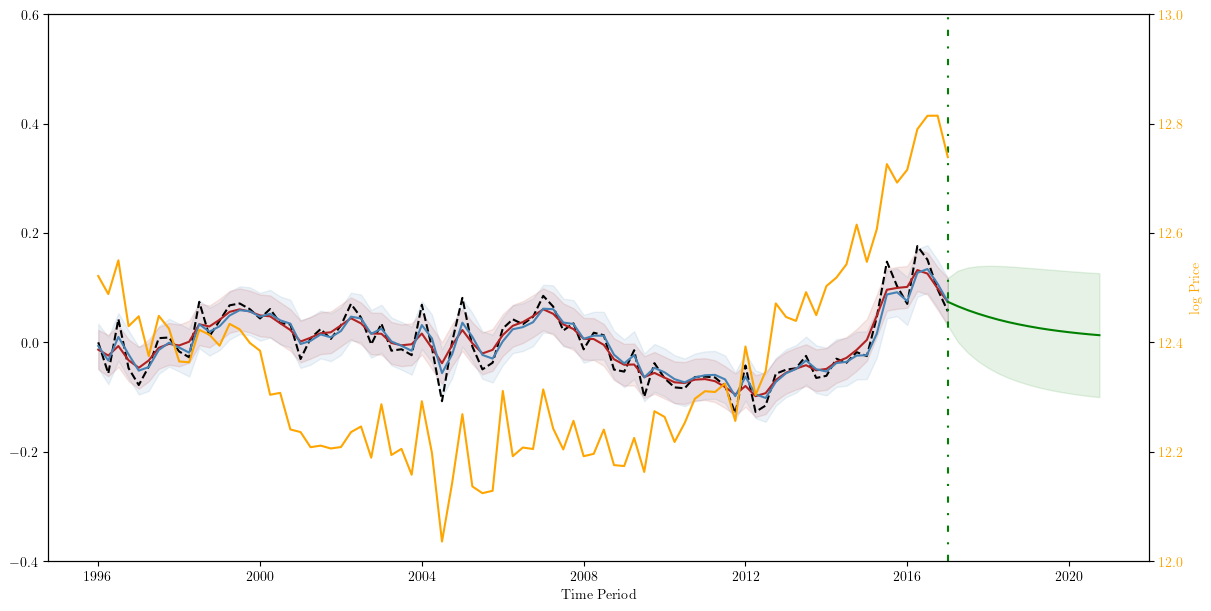

In [38]:
x_axis = gamma.index.to_timestamp()
average_price = df.groupby(df.index, sort=True)['price'].mean()

fig, ax1 = plt.subplots(figsize=(12,6), layout="constrained")

color1 = 'steelblue'
color2 = 'firebrick'
color3 = 'black'

# ----------------------------------------------
ax1.plot(x_axis, gamma, color=color3, label='Hedonic index', linestyle='--')
ax1.fill_between(x_axis, 
                 I_filtered[1:] - 2*np.sqrt(CI_filtered[1:]), 
                 I_filtered[1:] + 2*np.sqrt(CI_filtered[1:]), 
                 color=color1, label='95% CI of filtering', alpha=0.1)
ax1.fill_between(x_axis, 
                 I_smoothed[1:] - 2*np.sqrt(CI_smoothed[1:]), 
                 I_smoothed[1:] + 2*np.sqrt(CI_smoothed[1:]), 
                 color=color2, label='95% CI of smoothing', alpha=0.1)
# smoothed
ax1.plot(x_axis, I_smoothed[1:], color=color2, label='Smoothed market component')
# filtered
ax1.plot(x_axis, I_filtered[1:], color=color1, label='Filtered market component')
# predicted
ax1.plot(x_axis2, I_prediction, color='green', label='One ahead prediction')
ax1.fill_between(x_axis2, 
                 I_prediction - 2*np.sqrt(CI_prediction), 
                 I_prediction + 2*np.sqrt(CI_prediction), 
                 color='green', alpha=0.1)
ax1.axvline(x=x_axis2[0], color = 'green', linestyle=(0, (3, 5, 1, 5)))
ax1.set_xlabel('Time Period')
ax1.set_ylim([-0.4, 0.6])

# ----------------------------------------------
ax2 = ax1.twinx()
ax2.plot(x_axis, average_price, label='Average log-Price', color='orange')
ax2.set_ylabel('log Price', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim([12, 13])

## check outliers

In [39]:
# 95% intervall check
lowerline = list(I_smoothed[1:] - 2*np.sqrt(CI_smoothed[1:]))
upperline = list(I_smoothed[1:] + 2*np.sqrt(CI_smoothed[1:]))
gamma_list = list(gamma)

count = 0
for t in range(len(gamma_list)):
    if gamma_list[t] >= upperline[t] or gamma_list[t] <= lowerline[t]:
        count += 1
        print(f'{t+1}-th component is out of the range!!!')

print(count)

3-th component is out of the range!!!
11-th component is out of the range!!!
33-th component is out of the range!!!
35-th component is out of the range!!!
37-th component is out of the range!!!
79-th component is out of the range!!!
82-th component is out of the range!!!
7


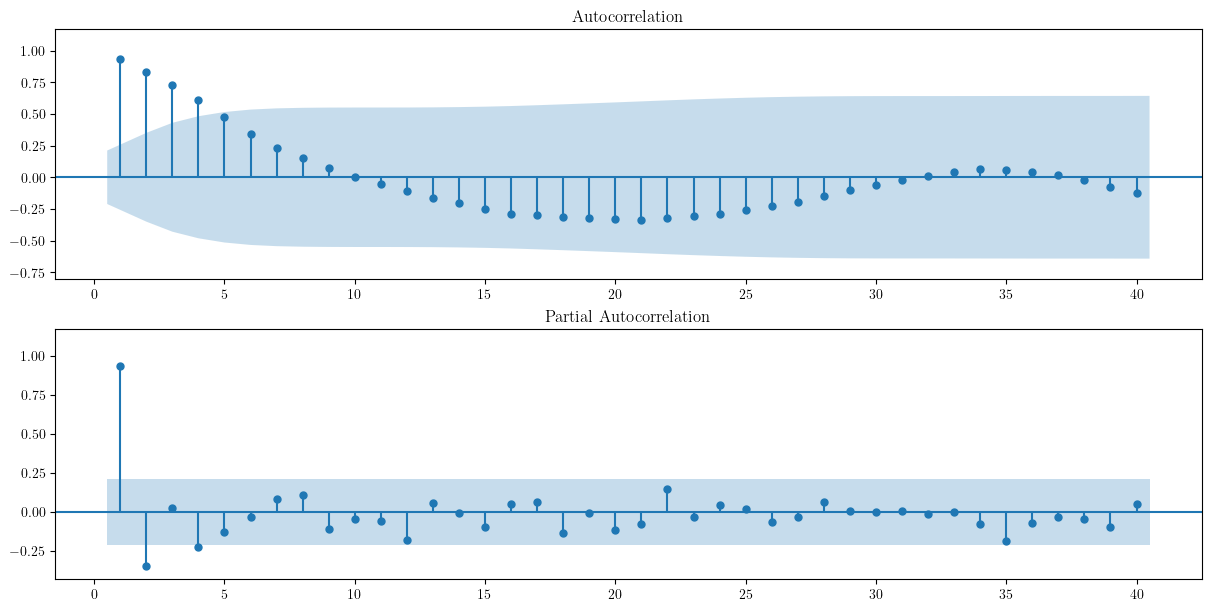

In [40]:
# ACF and PACF
fig = plt.figure(figsize=(12,6), layout="constrained")
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(I_smoothed, lags=40, ax=ax1, alpha=0.05, zero=False, auto_ylims=True)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(I_smoothed, lags=40, ax=ax2, alpha=0.05, zero=False, auto_ylims=True, method='ywm')
#plt.savefig('/Users/junyuchen/Desktop/Master Thesis/code/Plots/acf_pacf.png')
plt.show()

In [ ]:
I_smoothed